# CS4100 Final Project Code - Stock Performance Prediction using Sentiment Analysis on Tech News
#### Jayvardan Naidu, Brett Szlachciuk, Reilly Haughan


## Appendix
For our project, we tested the sentiment analysis accuracy of two NLP paradigms:
BERT, particularly distilBert to shorten runtime and use less memory, and NLTK with vader sentiment analysis.

Instructions:

Section 1 - data retreival

*   Run the stock news API code blocks to retrieve all necessary headline data

Section 2 - NLTK sentiment analysis

*   Run THE NLTK sentiment analysis portion
*   Run the following code block to see the sentiment analysis of a given stock overlayed onto its actual stock price (the given example is a week or so period of AAPL stock)

Section 3 - BERT sentiment analysis

*   Run the BERT model training code block
*   Run the block that asks for user input, entering a ticker and a start and end search date. Ex. 'TSLA, 02012019, 02012020'
*   The output should be the sentiment analysis of each article, 1 meaning positive, 0 meaning neutral, and -1 meaning negative
*   Along with these sentiment analysis outputs, you should see the graph of your chosen stock's movement between the dates you specified on top of a bar graph of the sentiment analysis results


Generally, run each block one by one and it will all work.

Insights:


*   The BERT model was trained on 4500 financial articles written between Jan 2018 and Dec 2019
*   The tickers the articles were written about were large tech companies (FAANG, Tesla, Microsoft, NVidia)












## Stock News API Code

In [ ]:
import requests
import json
import pandas as pd

In [ ]:
def str_to_dt(string):
    '''
    Util for get articles to convert the string date to a usable format
    
    Arguments:
        string (str): raw date string
        
    Returns:
        date (str): usable date string
    '''
    months = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
              'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
              'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
    
    day = string[5:7]
    month_str = string[8:11]
    month = months[month_str]
    year = string[12:16]
    
    date = f'{year}-{month}-{day}'
    
    return date

In [ ]:
def get_articles(tickers, start_date='', end_date='', num_articles=50, add_sentiment=False, articles=[]):
    '''
    Gets finance articles given tickers and an optional date range via https://stocknewsapi.com/
    
    Arguments:
        tickers (list): list of tickers/symbols that will be looked for
        (optional) start_date (str): the date of the earliest article the API will return (format: MMDDYYYY)
        (optional) end_date (str): the date of the latest article the API will return (format: MMDDYYYY)
        (optional) num_articles (int): the number of articles the API will return (<= 50)
        (optional) add_sentiment (boolean): add sentiment to the output entries if desired
        (optional) articles (list): a list of data to add the output to if desired
        
    Returns:
        articles (list): a dict with the format [[ticker, date, headline], ...]
    '''
    
    tickers_str = ''
    token = 'pj8lqwddvy14w2rasxkdvlr0mmh1x7izzoksktvy'
    
    # create tickers string
    for i in range(len(tickers)):
        if i == len(tickers) - 1:
            tickers_str += tickers[i]
        else:
            tickers_str += tickers[i] + ','
    
    # build url
    url = f'https://stocknewsapi.com/api/v1?tickers={tickers_str}&items={num_articles}&token={token}'
    
    # add date range if specified
    if start_date != '' and end_date != '':
        url += f'&date={start_date}-{end_date}'
    
    # hit API endpoint and get JSON response
    response = requests.get(url).content
    raw_json = json.loads(response)
    articles_json = raw_json['data']
    
    # clean response
    for article in articles_json:
        article_tickers = article['tickers']
        headline = article['title']
        raw_date = article['date']
        date = str_to_dt(raw_date)
        sentiment = article['sentiment']
        
        for ticker in article_tickers:
            if ticker in tickers:
                if add_sentiment:
                    articles.append([ticker, date, headline, sentiment])
                else:
                    articles.append([ticker, date, headline])
    
    return articles

In [ ]:
def get_max_articles(tickers, sentiment=False):
    '''
    Gets at most 200 articles per month for the given tickers from 2018-2019
    
    Arguments:
        tickers (list): list of tickers to determine what news to get
        (optional) sentiment (boolean): decides if sentiment will be included in the output
        
    Returns:
        articles (list): the articles in a list
    '''
    
    articles = []
    week_ranges = [(1, 7), (8, 14), (15, 21), (22, 28)]
    
    # get articles using the get_articles method
    for year in range(2018, 2020):
        for month in range(1, 13):
            for ranges in week_ranges:
                start = f'{month:02}{ranges[0]:02}{year}'
                end = f'{month:02}{ranges[1]:02}{year}'
            
                articles = get_articles(tickers, start_date=start, end_date=end,
                                        add_sentiment=sentiment, articles=articles)
            
    return articles

Here we are retrieving all of the articles headlines along with their dates and associated tickers. This data is used for both the NLTK and BERT sentiment analysis.

In [ ]:
# querying the API for the article info
articles = get_max_articles(['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG', 'MSFT', 'NVDA', 'TSLA'], sentiment=False)

KeyError: ignored

In [ ]:
def store_articles(articles, csv=False, file_name=''):
    '''
    Store the given articles to a dataframe and optionally a csv
    
    Arguments:
        articles (list): a list of the article entries to store
        (optional) csv (boolean): a flag to decide whether or not to save to csv
        (optional) file_name (str): a file name for the csv file without '.csv' at the end
        
    Return:
        df_articles (pd.Dateframe): a dataframe of the given data
    '''
    
    sentiment_added = len(articles[0]) == 4
    
    # set column names
    columns = ['Ticker', 'Date', 'Headline']
    if sentiment_added:
        columns.append('Sentiment')
    
    # create dataframe
    df_articles = pd.DataFrame(articles, columns=columns)
    
    # make sentiment values numerical if necessary
    if sentiment_added:
        df_articles['Sentiment'].replace({'Positive': 1, 'Neutral': 0, 'Negative': -1}, inplace=True)
        
    # save to csv if necessary
    if csv and file_name != '':
        df_articles.to_csv(f'{file_name}.csv')
        
    return df_articles

In [ ]:
# saving the articles to a dataframe
df_articles = store_articles(articles)
df_articles.head()

The sentiment in the above dataframe is from the API and was used to train the BERT NLP model. The code block below is the NLTK vader sentiment analysis 

## NLTK Sentiment Analysis

Note: You may have to run this code block twice, once to import NLTK and again to have the vader_lexicon download.

In [ ]:
!pip install twython
import nltk
nltk.download('vader_lexicon')  # <------------------ you have to download this then re run the code block

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#all of the necessary imports to get NLTK vader sentiment analyzer woeking
import pandas as pd
import numpy as np
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

#Make NLTK think like a financial jounralist by giving specific words
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -10,
    'slides': -10,
    'soars': 15,
    'rebounds': 5
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)




This code below is where we use NLTK to get a baseline sentiment analysis, so that we can compare it to the BERT sentiment analysis, and the dummy model.

In [ ]:
columns = ['ticker', 'date','headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(articles, columns=columns)


# Iterate through the headlines and get the polarity scores using vader
scores = scored_news['headline'].apply(vader.polarity_scores)

# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame.from_records(scores)

# Join the DataFrames
scored_news = scored_news.join(scores_df)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

NameError: ignored

In [ ]:
# Install yfinance and matplotlib package
!pip install yfinance
!pip install matplotlib

In [ ]:
# Import yfinance and matplotlib
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime as dt
import datetime as dat
import matplotlib.pyplot as plt
import seaborn as sns

# copy to preserve original
df_copy = scored_news

# checks if the given date is within range of the start and end date given
def in_range(start, end, curr):
  start_year = int(start[0:4])
  end_year = int(end[0:4])
  curr_year = curr.year

  start_month = int(start[5:7])
  end_month = int(end[5:7])
  curr_month = curr.month

  start_day = int(start[8:10])
  end_day = int(end[8:10])
  curr_day = curr.day

  start_dt = dt(start_year, start_month, start_day)
  end_dt = dt(end_year, end_month, end_day)
  curr_dt = dt(curr_year, curr_month, curr_day)

  return curr_dt >= start_dt and curr_dt <= end_dt

    

#this function will take in a start, and end date, how much of a delay, and a ticker,
#and will plot over the sentiment
def plotHistorical(ticker, df_scored, start_date, end_date):

  sns.set()

  # filter dataframe based off ticker
  df_scored = df_scored[df_scored['ticker'] == ticker]

  # filter dataframe based on date
  for index, row in df_scored.iterrows():
    if not in_range(start_date, end_date, row['date']):
        df_scored.drop(index, inplace=True)

  # Line chart-----

  # Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
  data = yf.download(ticker, start_date, end_date)

  # Bar chart-----

  # Group by date and ticker columns from scored_news and calculate the mean
  mean_c = df_scored.groupby(['date', 'ticker']).mean()

  # Unstack the column ticker
  mean_c = mean_c.unstack('ticker')

  # Get the cross-section of compound in the 'columns' axis
  mean_c = mean_c.xs('compound', axis='columns')

  # plotting-----

  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()

  ax1.plot(data["Adj Close"])
  ax2.bar(df_scored['date'], df_scored['compound'], alpha=0.5)

  fig.set_size_inches(40, 8)

  plt.show()

plotHistorical('AAPL', df_copy, '2018-12-12', '2019-01-10')

The above graph is the Apple stock performance for a week or so at the end of 2018. Overlayed on top is a bar graph which representes the sentiment of tech news articles on that day. Ideally, there is a correlation between the stock performance and the sentiment of the day taking into account that the sentiment of the articles may only affect the stock performance anywhere between immediately and a few days.

#### Accuracy Testing

Here we test the accuracy of sentiment to stock performance. Our accuracy is calculated by, at each day, checking if the positive or negative sentiment of tech articles positively or negatively affected the stock. Then we get find the percent of correct predictions among all predictions for the final percentage.

In [ ]:
#function to calculate the accuracy of a NLP sentiment model vs price movement
index = data.index
dates = list(index)

def getAccuracy(classifierOut, dates):
  count = 0
  total = 0
  for date in dates:
    t = date.to_pydatetime().date()
    row = classifierOut.loc[classifierOut['date'] == t]

    if row.empty:
      continue
    else:
      total += 1

    price = data.loc[date]
    delta = price['Open'] - price['Close']

    compound = row['compound'].values[0]

    if compound > 0 and delta > 0:
      count = count + 1
    elif compound < 0 and delta < 0:
      count = count + 1
  print('The accuracy score is: ' + str((count/total) * 100) + '%')

scored_test = scored_news[scored_news['ticker'] == "AAPL"]
getAccuracy(scored_test, dates)

The results are underwhelming. This seems to indicate that our NLTK predictor is innacurate. It is possible performance would benefit from taking into acount the delay of the affect of tech news articles. Meaning after a prediction is made by a journalist the stock may only make major moves in the days following.

## BERT Sentiment Analysis

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 182 kB 67.5 MB/s 
     |████████████████████████████████| 7.6 MB 48.3 MB/s 


Train the BERT Model, specifically DistilBert, on sentiment values for financial articles pulled from an API with Logistic Regression.

In [ ]:
#BERT impl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers 
import warnings
warnings.filterwarnings('ignore')


"""dataset"""
# import dataset csv and 
# find how many datasets are labeled positive, negative, neutral
df = pd.read_csv('https://raw.githubusercontent.com/jai-naidu/CS4100/main/articles_50perweek_2018-2019_BERT.csv', delimiter = ',', header = None)
print(df.head())
value_count = df[4].value_counts()

"""train model"""
# Pre-trained model to be used in embedding sentences. We use distilbert to reduce the time needed to compute
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# tokenize dataset
tokenized = df[3].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# pad the sentences
longest_sentence = 0
for i in tokenized.values:
  if len(i) > longest_sentence:
      longest_sentence = len(i)

padded_sentences = np.array([i + [0] * (longest_sentence - len(i)) for i in tokenized.values])

# mask so bert is not confused by padding
mask = np.where(padded_sentences != 0, 1, 0)

# assign tensors
input_ids = torch.tensor(padded_sentences)  
mask = torch.tensor(mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=mask)

# add the output of each sentence to regression features
features = last_hidden_states[0][:,0,:].numpy()
labels = df[4]

# make a train/test split of the dataframe using the features we defined earlier
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

# train the logistic regression model on the training data
lr = LogisticRegression()
lr.fit(train_features, train_labels)

# score the model
score = lr.score(test_features, test_labels)

print('Score compared to the testing dataset: ')
print(score)







In [ ]:
# Dummy Classifier score
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()

scores = cross_val_score(dummy, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
"""
Test of applying stock article headlines to the Linear Regression trained BERT model
"""

import pandas as pd

columns = ['ticker', 'date', 'headline']

# For now test with the dataset pn we defined
data = pd.DataFrame(articles, columns=columns)
apple_data = data[data['ticker'] == 'AAPL']


#begin tokenizing
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
tokenized_headlines = apple_data['headline'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# pad the sentences
longest_sentence = 0
for i in tokenized.values:
  if len(i) > longest_sentence:
      longest_sentence = len(i)

padded_sentences = np.array([i + [0] * (longest_sentence - len(i)) for i in tokenized_headlines.values])

# mask so bert is not confused by padding
mask = np.where(padded_sentences != 0, 1, 0)

# assign tensors
input_ids = torch.tensor(padded_sentences)  
mask = torch.tensor(mask)

# 
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=mask)

# add the output of each sentence to something the regression model can interpret
features = last_hidden_states[0][:,0,:].numpy()

# Return sentiment values from trained model
scores = lr.predict(features)


scores_int = []
for score in scores:
  scores_int.append(int(score))

scores_df = pd.DataFrame(scores_int, columns=['Sentiment_Value'])


apple_data = apple_data.join(scores_df)
print(apple_data)

print(apple_data.columns)


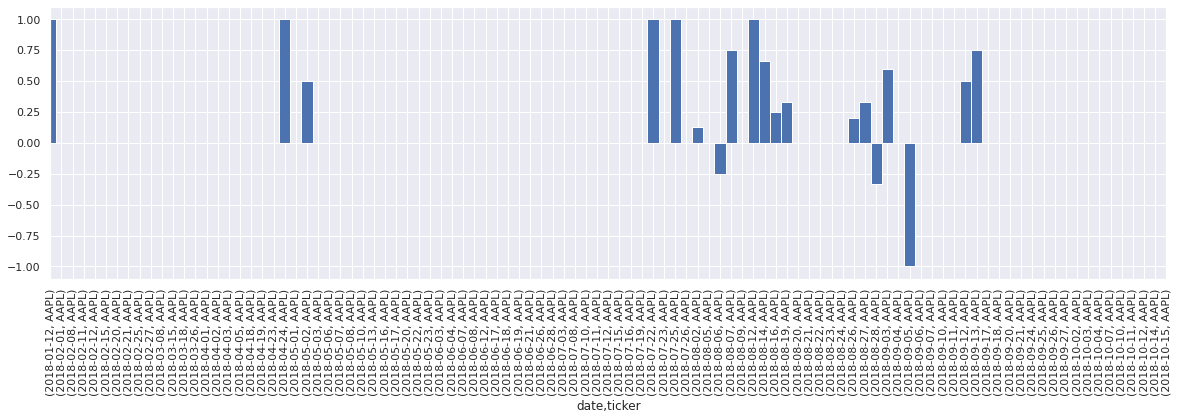

In [ ]:
import yfinance as yf  
import matplotlib.pyplot as plt
from datetime import datetime as dt
import datetime as dat
import matplotlib.pyplot as plt
import seaborn as sns



import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = apple_data.groupby(['date', 'ticker']).mean()

# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('Sentiment_Value', axis='columns')

# Plot a bar chart with pandas
mean_c.plot(kind='bar', figsize=(20,5), width=1)

plt.xlim([0, 100])

plt.show()

#### NOTE: You have to run this block twice for the graph to resize correctly

[*********************100%***********************]  1 of 1 completed


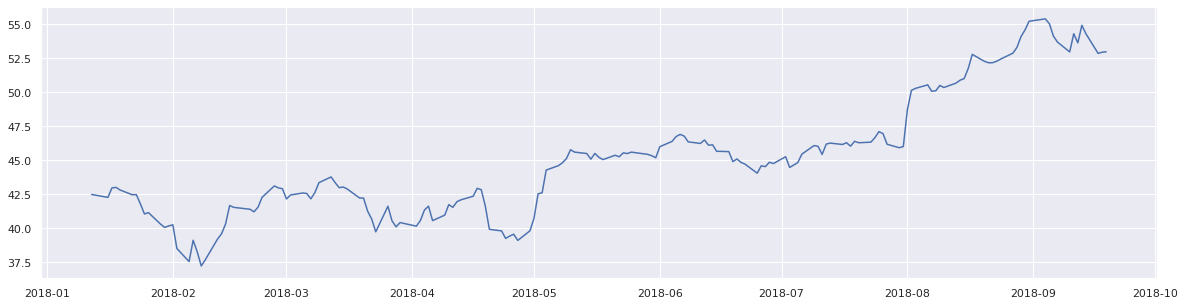

In [ ]:
#Stock data
stock_data = yf.download('AAPL', '2018-01-12', '2018-09-20')

plt.plot(stock_data["Adj Close"])
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

#### NOTE: The following code block will ask you to enter a ticker. It must be capitalized e.g. AMZN, TSLA, etc.

In [ ]:
"""
Allow the user to enter a dataframe, tokenize the headline sentences, and 
use the trained model to evaluate sentiment(lr.predict)

Returns: A DataFrame with columns: ticker, date, headline, Sentiment_Value
"""

ticker = input('Enter the ticker you want to evaluate(MUST BE CAPITALIZED): ')

def bert_sentiment_analysis(ticker):
  input_data = get_max_articles([ticker], sentiment=False)
  data = pd.DataFrame(input_data, columns=columns)
  ticker_df = data[data['ticker'] == ticker]
  return sentiment_analysis(ticker_df), ticker_df


def sentiment_analysis(df):
  #begin tokenizing
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  tokenized_headlines = df['headline'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  # pad the sentences
  longest_sentence = 0
  for i in tokenized.values:
    if len(i) > longest_sentence:
        longest_sentence = len(i)

  padded_sentences = np.array([i + [0] * (longest_sentence - len(i)) for i in tokenized_headlines.values])

  # mask so bert is not confused by padding
  mask = np.where(padded_sentences != 0, 1, 0)
  # assign tensors
  input_ids = torch.tensor(padded_sentences)  
  mask = torch.tensor(mask)

  # 
  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=mask)

  # add the output of each sentence to something the regression model can interpret
  features = last_hidden_states[0][:,0,:].numpy()

  # Return sentiment values from trained model
  scores = lr.predict(features)

  scores_int = []
  for score in scores:
    scores_int.append(int(score))

  scores_df = pd.DataFrame(scores_int, columns=['Sentiment_Value'])


  df = df.join(scores_df)
  print(df)
  
  return df


# Sentiment values for articles in the date range
sentiment_scores = bert_sentiment_analysis(ticker)


Enter the ticker you want to evaluate(MUST BE CAPITALIZED): TSLA
     ticker  ... Sentiment_Value
0      TSLA  ...               0
1      TSLA  ...               0
2      TSLA  ...               0
3      TSLA  ...               0
4      TSLA  ...               0
...     ...  ...             ...
2054   TSLA  ...               0
2055   TSLA  ...               0
2056   TSLA  ...               0
2057   TSLA  ...               1
2058   TSLA  ...               1

[2059 rows x 4 columns]


#### NOTE: You will probably have to run this code block twice for the graphs to resize properly. Also, if you click on the graphs they increase in size and you can scroll horizontally to view the sentiment and stock price.

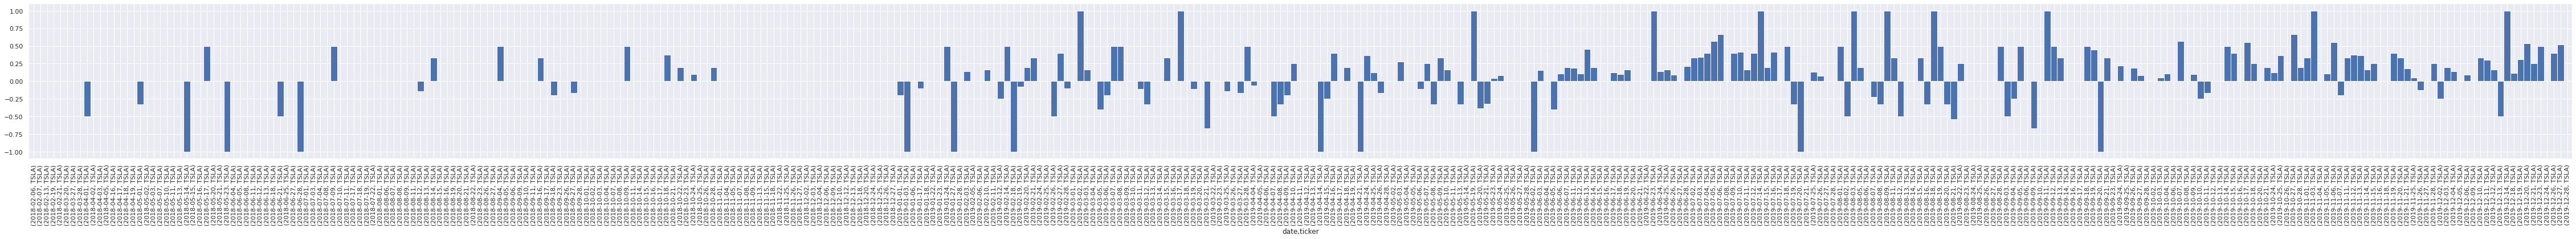

[*********************100%***********************]  1 of 1 completed


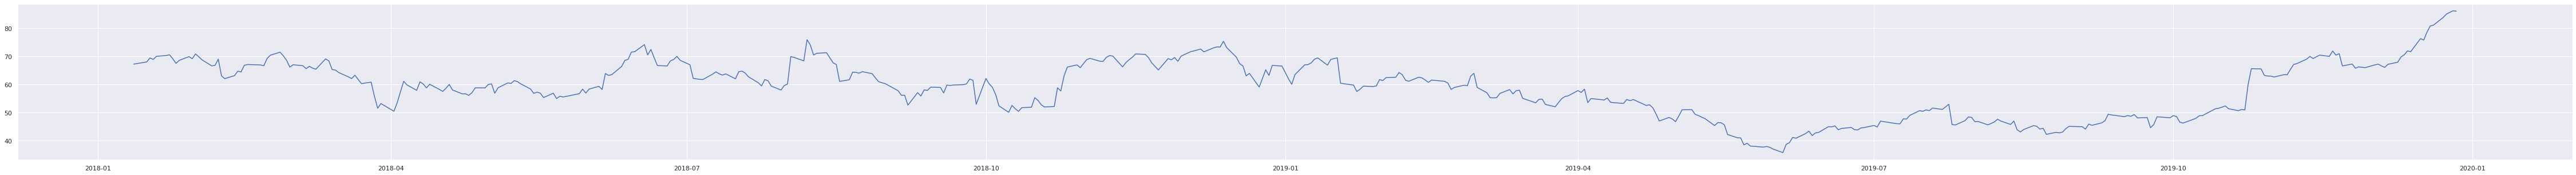

In [ ]:
"""
This function will take in a ticker and number of days to delay and plots a bar graph
of the average sentiment values of article headlines for the ticker for each day,
and after plots the stock price of the ticker in the same date range.`
"""
def plotHistorical(ticker, df, delay=7):
  sns.set()

  # get right bound date
  today = dt.now()
  end = today.strftime('%Y-%m-%d')

  # get left bound date
  delay = dat.timedelta(delay)
  left_bound = today - delay
  start = left_bound.strftime('%Y-%m-%d')

  # Group by date and ticker columns from scored_news and calculate the mean
  mean_c = df.groupby(['date', 'ticker']).mean()

  # Get the cross-section of compound in the 'columns' axis
  mean_c = mean_c.xs('Sentiment_Value', axis='columns')

  # Plot a bar chart with pandas
  mean_c.plot(kind='bar', figsize=(80,5), width=1)

  plt.show()

  #Stock data
  stock_data = yf.download(ticker, '2018-01-12', '2019-12-30')

  plt.plot(stock_data["Adj Close"])
  plt.rcParams["figure.figsize"] = (80,5)
  plt.show()

# Sentiment values charted over stock price graph for the same time period
plotHistorical(ticker, sentiment_scores)

Accuracy score for the BERT-generated sentiment values relative to stock price movements

In [ ]:
#function to calculate the accuracy of a BERT sentiment model vs price movement
index = stock_data.index
dates = list(index)
def getAccuracyBert(classifierOut, dates):
  count = 0
  total = 0
  for date in dates:
    t = date.to_pydatetime().date().strftime('%Y-%m-%d')
    row = classifierOut.loc[classifierOut['date'] == t]

    if row.empty:
      continue
    else:
      total += 1

    price = stock_data.loc[date]
    delta = price['Open'] - price['Close']

    compound = row['Sentiment_Value'].values[0]

    if compound > 0 and delta > 0:
      count = count + 1
    elif compound < 0 and delta < 0:
      count = count + 1
  print('The accuracy score is: ' + str((count/total) * 100) + '%')

getAccuracyBert(sentiment_scores, dates)

The accuracy score is: 4.615384615384616%
